# Forecasting Bike Hire Trips

### In this first step we read in the CSVs from the start of 2014 until the end of August in 2017.

In [1]:
%matplotlib inline
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pylab import rcParams
import statsmodels.api as sm
import warnings
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 14, 7
warnings.filterwarnings("ignore")

In [2]:
time_start = dt.datetime(2014,1,1)
time_end = dt.datetime(2017,9,1,0,0,0)
station_start = 6184
station_end = 6015
missing_data = {
    2014:[dt.datetime(2014,4,15), dt.datetime(2014,11,15)],
    2015:[dt.datetime(2015,4,15), dt.datetime(2015,11,15)],
    2016:[dt.datetime(2016,4,15), dt.datetime(2016,11,15)],
    2017:[dt.datetime(2017,4,15), dt.datetime(2017,11,15)]
}

In [3]:
def read_csv(year, month):
    file = os.path.join('data', f'BixiMontrealRentals{year}', f'OD_{year}-{month:02}.csv')
    df = pd.read_csv(file, parse_dates=['start_date', 'end_date'])
    df.sort_values(by=['start_date'], inplace=True)
    date_range = (df['start_date'] >= time_start) & (df['end_date'] < time_end)
    df = df.loc[date_range]
    route = (df['start_station_code'] == station_start) & (df['end_station_code'] == station_end)
    df = df.loc[route]
    return df

In [4]:
df = pd.DataFrame()
for year in range(2014,2018):
    print(year)
    for month in range(1,13):
        try:
            df = df.append(read_csv(year, month))
        except FileNotFoundError:
            pass
df.sort_values(by=['start_date'], inplace=True)
df.set_index(['start_date'], inplace=True)

2014
2015
2016
2017


In [5]:
df.head(5)

,start_station_code,end_date,end_station_code,duration_sec,is_member
start_date,,,,,
2014-04-15 07:53:00,6184,2014-04-15 08:02:00,6015,517,1
2014-04-16 16:55:00,6184,2014-04-16 17:06:00,6015,686,1
2014-04-16 18:11:00,6184,2014-04-16 18:18:00,6015,439,1
2014-04-16 18:53:00,6184,2014-04-16 19:03:00,6015,580,1
2014-04-17 08:58:00,6184,2014-04-17 09:05:00,6015,412,1


### Now we can begin the forecast.

number of hires and mean journey time per time frame

In [6]:
df['hires'] = 1
daily_hires, weekly_hires, monthly_hires = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
daily_hires[['hire_count', 'mean_duration_sec']] = df.resample('D').agg({'hires':'sum','duration_sec':'mean'})
weekly_hires[['hire_count', 'mean_duration_sec']] = df.resample('W-MON').agg({'hires':'sum','duration_sec':'mean'})
monthly_hires[['hire_count', 'mean_duration_sec']] = df.resample('MS').agg({'hires':'sum','duration_sec':'mean'})
daily_hires.reset_index(inplace=True)
weekly_hires.reset_index(inplace=True)
monthly_hires.reset_index(inplace=True)

In [7]:
def remove_missing_data(df):
    for year in range(2014, 2018):
        indices = (df['start_date'] < missing_data[year][0]) & (df['start_date'] > missing_data[year][1])
        df[indices]['hire_count'] = np.nan
    return df

In [8]:
daily_hires = remove_missing_data(daily_hires)
weekly_hires = remove_missing_data(weekly_hires)
monthly_hires = remove_missing_data(monthly_hires)
daily_hires.set_index(['start_date'], inplace=True)
weekly_hires.set_index(['start_date'], inplace=True)
monthly_hires.set_index(['start_date'], inplace=True)

Text(0.5, 1.0, 'daily hires')

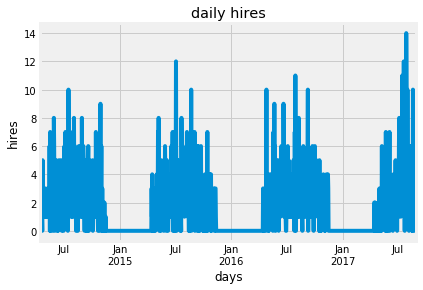

In [9]:
daily_hires['hire_count'].plot()
plt.xlabel('days')
plt.ylabel('hires')
plt.title('daily hires')

Text(0.5, 1.0, 'weekly hires')

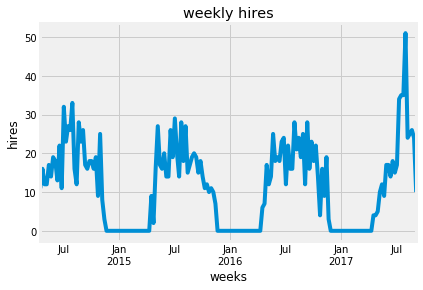

In [10]:
weekly_hires['hire_count'].plot()
plt.xlabel('weeks')
plt.ylabel('hires')
plt.title('weekly hires')

Text(0.5, 1.0, 'monthly hires')

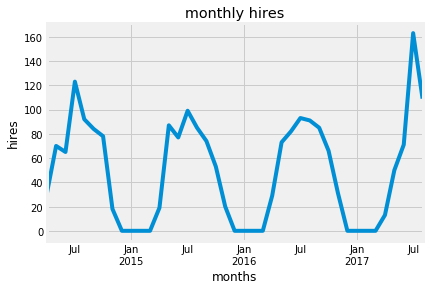

In [11]:
monthly_hires['hire_count'].plot()
plt.xlabel('months')
plt.ylabel('hires')
plt.title('monthly hires')

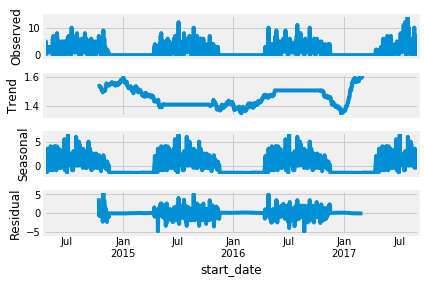

In [12]:
decomposition = sm.tsa.seasonal_decompose(daily_hires['hire_count'].dropna(), freq=365)
decomposition.plot()
plt.show()

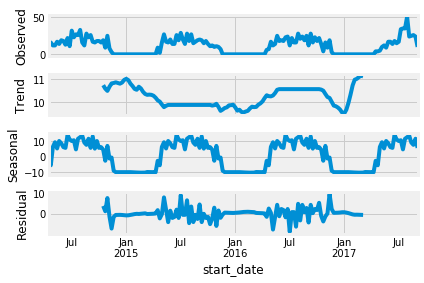

In [13]:
decomposition = sm.tsa.seasonal_decompose(weekly_hires['hire_count'].dropna(), freq=52)
decomposition.plot()
plt.show()

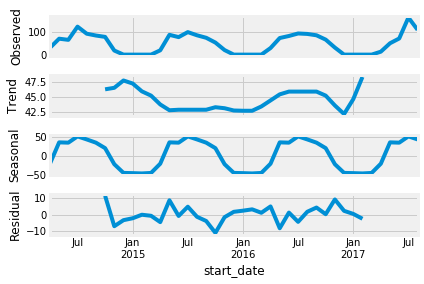

In [14]:
decomposition = sm.tsa.seasonal_decompose(monthly_hires['hire_count'].dropna(), freq=12)
decomposition.plot()
plt.show()

ARIMA

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
daily_pdq = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p, d, q))]
weekly_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
monthly_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [16]:
for param in pdq:
    for param_seasonal in weekly_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(weekly_hires['hire_count'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:1468.4631497173764
ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:3835.046007234763
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:818.505411560609
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:824.5068349246386
ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:814.5131734830545
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:493.47229456185687
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:1340.0512496962583
ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:5523.124000465862
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:808.1255409216019
ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:823.2349948244439
ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:804.2951023562617
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:492.3400899018275
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:1164.0595481843302
ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:5213.299601898184
ARIMA(0, 1, 0)x(0, 1, 0, 52)52 - AIC:875.4951999611167
ARIMA(0, 1, 0)x(1, 0, 0, 52)52 - AIC:823.0364501843768
ARIMA(0, 1, 0)x(1, 0, 1, 52)52 - AIC:5165.259972484359
ARIMA(0, 1, 0)x(1, 1, 0, 52)52 - AIC:516.0019841768094
ARIMA(0

In [18]:
mod = sm.tsa.statespace.SARIMAX(weekly_hires['hire_count'],
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6905      0.253      2.728      0.006       0.194       1.187
ma.L1         -0.4422      0.310     -1.426      0.154      -1.050       0.166
ar.S.L52      -0.2570      0.105     -2.445      0.014      -0.463      -0.051
sigma2        43.1413      6.238      6.916      0.000      30.915      55.368


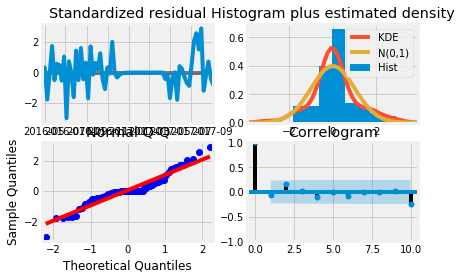

In [19]:
results.plot_diagnostics()
plt.show()

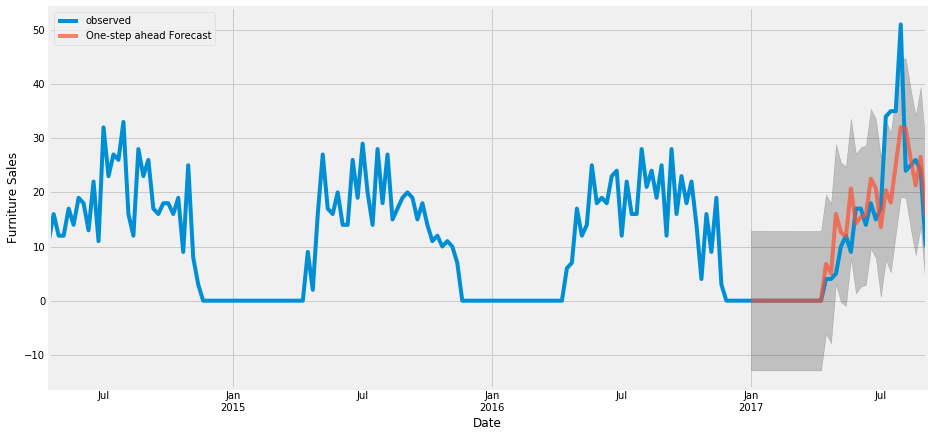

In [22]:
pred = results.get_prediction(start=dt.datetime(2017,1,2), dynamic=False)
pred_ci = pred.conf_int()
ax = weekly_hires['hire_count'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [24]:
y_forecasted = pred.predicted_mean
y_truth = weekly_hires['hire_count']['2017-01-02':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 38.95
The Root Mean Squared Error of our forecasts is 6.24


In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = weekly_hires['hire_count'].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()